# Calculate and plot meridional heat transport

## Uses two methods because of diagnostics available:
- From surface heat flux assuming steady state
- From temp_yflux_adv diagnostic (so does not include submeso or gm/diffusion if they are on)

In [3]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import pandas as pd
import IPython.display
import cmocean as c
from dask.distributed import Client


import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata

print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Available exptdata keys:  ['1deg', '025deg', '01deg']


In [4]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [5]:
#cc.start_cluster()
client = Client('tcp://10.0.64.2:8786', local_dir='/local/g40/amh157')
client

Client Scheduler: tcp://10.0.64.2:8786 Dashboard: http://10.0.64.2:8787/status,Cluster Workers: 6 Cores: 6 Memory: 24.00 GB


In [6]:
# Infer from surface heat flux:
def find_MHF(ekey):
    
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    #n_files = 1
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']

    shflux = cc.get_nc_variable(expt, 'ocean_month.nc', 'net_sfc_heating',
                          n=n_files, time_units = time_units, offset=offset, use_cache=True)
    shflux_am = shflux.mean('time').load()
    area = cc.get_nc_variable(expt, 'ocean_grid.nc','area_t',n=1).load()
    lat = cc.get_nc_variable(expt, 'ocean_grid.nc','geolat_t',n=1).load()
    latv = cc.get_nc_variable(expt, 'ocean_grid.nc','yt_ocean',n=1).load()
    MHF = np.zeros_like(latv)
    for i in range(len(latv)):
        inds = lat < latv[i]
        MHF[i] = np.sum(area.where(lat < latv[i])*shflux_am.where(lat < latv[i]))

    MHF = MHF + (MHF[0]-MHF[-1])/2
    
    return latv, MHF

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Saving cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_B1_ocean_month.nc_net_sfc_heating_-12_days-since-1718-01-01_-87658_False.pkl
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Saving cache file cache_get_nc_variable_025deg_jra55v13_iaf_gmredi_ocean_month.nc_net_sfc_heating_-30_days-since-1718-01-01_-87658_False.pkl
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/co

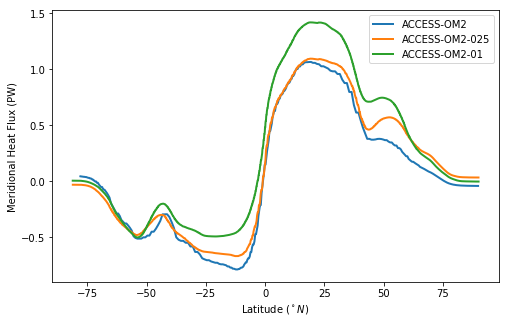

In [7]:
# Plot just surface heat flux inferred method:
fig = plt.figure(figsize=(8,5))
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Meridional Heat Flux (PW)')
for i, ekey in enumerate(exptdata.exptdict.keys()):
    latv, MHF = find_MHF(ekey)

    plt.plot(latv,MHF/1.e15,linewidth=2, label=exptdata.exptdict[ekey]['desc'])

plt.legend()
savefigure('meridional_heat_transport')

In [8]:
# use temp_yflux_adv diagnostics:
def find_MHF_tempadv(ekey):
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    #n_files = 1
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']

    if (ekey == '01deg'):
        temp_yflux_adv = cc.get_nc_variable(expt, 'ocean_month.nc', 'temp_yflux_adv_int_z',
                                            n=n_files, time_units = time_units, offset=offset, use_cache=True)
        #temp_yflux_submeso = cc.get_nc_variable(expt, 'ocean_month.nc', 'temp_yflux_submeso_int_z',
        #                                    n=n_files, time_units = time_units, offset=offset)
        MHF = temp_yflux_adv.mean('time').sum('xt_ocean').load()
        #MHF = temp_yflux_submeso.mean('time').sum('xt_ocean').load()
    else:
        temp_yflux_adv = cc.get_nc_variable(expt, 'ocean.nc', 'temp_yflux_adv',
                                            n=n_files, time_units = time_units, offset=offset, use_cache=True)
        MHF = temp_yflux_adv.mean('time').sum('st_ocean').sum('xt_ocean').load()

    latv = cc.get_nc_variable(expt, 'ocean_grid.nc','yu_ocean',n=1).load()
    return latv, MHF

(-2, 2.5)

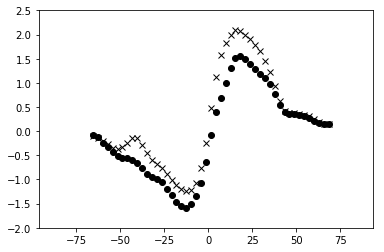

In [9]:
# Read in observed meridional heat transport from Trenberth and Caron (http://www.cgd.ucar.edu/cas/catalog/ocean/ohts/rean_ohts.html)
#f = open('ANNUAL_TRANSPORTS_1985_1989.ascii.txt', 'r') # 'r' = read
df=pd.read_csv('ANNUAL_TRANSPORTS_1985_1989.ascii.txt', sep=' ',skiprows=1,skipinitialspace=True)
obs_lat = df.values[:,0]/100.
obs_ncep = df.values[:,6]/100.
obs_ecmwf = df.values[:,14]/100.
#obs_ncep2 = df.values[:,18]/100.
plt.plot(obs_lat,obs_ncep,'xk')
plt.plot(obs_lat,obs_ecmwf,'ok')
plt.ylim([-2, 2.5])
#plt.plot(obs_lat,obs_ncep2)
#df.values[:,0]
#array([[ 1. ,  2. ,  3. ],
#       [ 4. ,  5.5,  6. ]])
#my_data = genfromtxt(, delimiter=' ', dtype=None)
#print(my_data)
#f.close()from astropy.io import ascii
#data = ascii.read("ANNUAL_TRANSPORTS_1985_1989.ascii")
#print(data)

Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_B1_ocean_month.nc_net_sfc_heating_-12_days-since-1718-01-01_-87658_False.pkl
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Saving cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_B1_ocean.nc_temp_yflux_adv_-12_days-since-1718-01-01_-87658_False.pkl
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_gmredi_ocean_month.nc_net_sfc_heating_-30_days-since-1718-01-01_-87658_False.pkl
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook

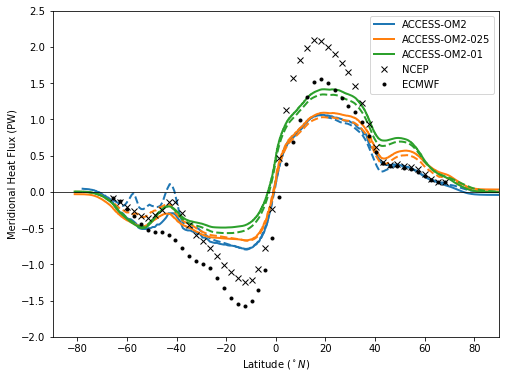

In [10]:
# plot both surface heat flux, temp_yflux_adv methods and observations:
fig = plt.figure(figsize=(8,6))
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Meridional Heat Flux (PW)')
for i, ekey in enumerate(exptdata.exptdict.keys()):
    latv, MHF = find_MHF(ekey)
    latv_adv, MHF_adv = find_MHF_tempadv(ekey)

    hand = plt.plot(latv,MHF/1.e15,linewidth=2, label=exptdata.exptdict[ekey]['desc'])# + ' surface heat flux')
    plt.plot(latv_adv,MHF_adv/1.e15,'--',linewidth=2, label='',color=hand[0].get_color())#, label=exptdata.exptdict[ekey]['desc'] + ' resolved advection',color=hand[0].get_color())

plt.plot(obs_lat,obs_ncep,'xk',label='NCEP', markersize=6)
plt.plot(obs_lat,obs_ecmwf,'ok',label='ECMWF', markersize=3)
plt.plot([-90, 90],[0,0],'k-',linewidth=0.75)
plt.legend()
plt.xlim([-90.,90.])
plt.ylim([-2, 2.5])

savefigure('meridional_heat_transport_withadv_withobs')

In [ ]:
cc.get_ncfiles(exptdata.exptdict['1deg']['expt'])

In [ ]:
cc.get_variables(exptdata.exptdict['01deg']['expt'],'ocean_month.nc')